In [311]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import pandas_profiling
import numpy as np
import re
import requests
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss, f1_score
from xgboost import XGBClassifier
import warnings
import types

warnings.filterwarnings('ignore')

In [205]:
train_values = pd.read_csv('training_set_values.csv')
train_labels = pd.read_csv('training_set_labels.csv')
test_values = pd.read_csv('test_set_values.csv')
result_df = pd.read_csv('test_set_values.csv')

In [206]:
train_df = train_values.merge(train_labels,on='id',how='inner')

In [207]:
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [208]:
train_df.shape

(59400, 41)

In [209]:
train_df.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [210]:
# Generate a profile report of the data to examine. 
#pandas_profiling.ProfileReport(train_df)

In [211]:
def funder_cleaning(train):
    if train['funder']=='Government Of Tanzania':
        return 'government'
    elif train['funder']=='Danida':
        return 'danida'
    elif train['funder']=='Hesawa':
        return 'hesawa'
    elif train['funder']=='Rwssp':
        return 'rwssp'
    elif train['funder']=='World Bank':
        return 'world_bank'    
    else:
        return 'other'
    
train_df['funder']= train_df.apply(lambda row: funder_cleaning(row), axis=1)
test_values['funder']= test_values.apply(lambda row: funder_cleaning(row), axis=1)

In [212]:
#Lets divide installer column into 5 categories, top 5 will be remained as it is and after that they will be categorised into other
def installer_cleaning(train):
    if train['installer']=='DWE':
        return 'dwe'
    elif train['installer']=='Government':
        return 'government'
    elif train['installer']=='RWE':
        return 'rwe'
    elif train['installer']=='Commu':
        return 'commu'
    elif train['installer']=='DANIDA':
        return 'danida'    
    else:
        return 'other'
    
train_df['installer']= train_df.apply(lambda row: installer_cleaning(row), axis=1)
test_values['installer']= test_values.apply(lambda row: installer_cleaning(row), axis=1)

In [213]:
# Drop high cardinality values and recorded_by column because it is constant
train_df = train_df.drop(['lga', 'scheme_name', 'subvillage', 'ward', 'wpt_name'], axis=1)
test_values = test_values.drop(['lga', 'scheme_name', 'subvillage', 'ward', 'wpt_name'], axis=1)

In [214]:
train_df.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                      0
gps_height                  0
installer                   0
longitude                   0
latitude                    0
num_private                 0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
public_meeting           3334
recorded_by                 0
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_group              0
source                      0
source_type                 0
source_class                0
waterpoint

In [215]:
#public_meeting
train_df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [216]:
#Since most of the values are True, as of now lets insert True for the missing values. Scope to alter the values in future
train_df.public_meeting = train_df.public_meeting.fillna('Unknown')
test_values.public_meeting = test_values.public_meeting.fillna('Unknown')

In [217]:
train_df['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [218]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def scheme_wrangler(row):
    '''Keep top 5 values and set the rest to 'other'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    else:
        return 'other'

train_df['scheme_management'] = train_df.apply(lambda row: scheme_wrangler(row), axis=1)
test_values['scheme_management'] = test_values.apply(lambda row: scheme_wrangler(row), axis=1)

In [219]:
#permit
train_df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [220]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

train_df.permit = train_df.permit.fillna('Unknown')
test_values.permit = test_values.permit.fillna('Unknown')

In [221]:
train_df.isna().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64

In [222]:
train_df = train_df.drop(['recorded_by'], axis=1)
test_values = test_values.drop(['recorded_by'], axis=1)

In [223]:
train_df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [224]:
train_df['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [225]:
train_df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [226]:
# Since extraction_type, extraction_type_group, extraction_type_class features has similar values drop two of them
train_df = train_df.drop(['extraction_type','extraction_type_group'],axis=1)
test_values = test_values.drop(['extraction_type','extraction_type_group'],axis=1)

In [227]:
train_df['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [228]:
train_df['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [229]:
# Since payment_type and payment features has similar values drop one of them
train_df = train_df.drop(['payment'],axis=1)
test_values = test_values.drop(['payment'],axis=1)

In [230]:
train_df['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [231]:
train_df['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [232]:
# Since quality_group and quality are correlated drop one of them
train_df = train_df.drop(['quality_group'],axis=1)
test_values = test_values.drop(['quality_group'],axis=1)

In [233]:
train_df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [234]:
train_df['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [235]:
# Since quantity_group and quantity features has similar values drop one of them
train_df = train_df.drop(['quantity'],axis=1)
test_values = test_values.drop(['quantity'],axis=1)

In [236]:
train_df['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [237]:
train_df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [238]:
train_df['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [239]:
#source and source_type are same because in source_type some values are merged together. 
# we can drop one of the column.
train_df = train_df.drop(['source'],axis=1)
test_values = test_values.drop(['source'],axis=1)

In [240]:
train_df['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [241]:
train_df['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [242]:
# Since waterpoint_type_group and waterpoint_type features has similar values drop one of them
train_df = train_df.drop(['waterpoint_type'],axis=1)
test_values = test_values.drop(['waterpoint_type'],axis=1)

In [243]:
train_df['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [244]:
train_df['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [245]:
# Since management_group and management features has similar values drop one of them
train_df = train_df.drop(['management'],axis=1)
test_values = test_values.drop(['management'],axis=1)

In [246]:
#convert status group label into numerical data
val_status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
train_df['status_group_vals']=train_df.status_group.replace(val_status_group)

In [247]:
train_df = train_df.drop(['status_group'],axis=1)

In [248]:
train_df.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(train_df.date_recorded)
train_df.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train_df.columns]
train_df.days_since_recorded = train_df.days_since_recorded.astype('timedelta64[D]').astype(int)

test_values.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(test_values.date_recorded)
test_values.columns = ['days_since_recorded' if x=='date_recorded' else x for x in test_values.columns]
test_values.days_since_recorded = test_values.days_since_recorded.astype('timedelta64[D]').astype(int)

In [249]:
# I will keep only region between geographical data, it is enough for model. Also i will drop num_private because it hasn't
# been given any description on DrivenData.We expect id to not contain any useful information so that gets
# dropped too. wpt_name is also not required, it gives only waterpoint name

train_df = train_df.drop(['region','region_code','gps_height', 'longitude', 'latitude', 'district_code',
             'num_private', 'id'], axis=1)

test_values = test_values.drop(['region','region_code','gps_height', 'longitude', 'latitude', 'district_code',
             'num_private', 'id'], axis=1)

In [250]:
train_df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [251]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train_df['construction_year'] = train_df.apply(lambda row: construction_wrangler(row), axis=1)
test_values['construction_year'] = test_values.apply(lambda row: construction_wrangler(row), axis=1)

In [252]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   days_since_recorded    59400 non-null  int32  
 2   funder                 59400 non-null  object 
 3   installer              59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   population             59400 non-null  int64  
 6   public_meeting         59400 non-null  object 
 7   scheme_management      59400 non-null  object 
 8   permit                 59400 non-null  object 
 9   construction_year      59400 non-null  object 
 10  extraction_type_class  59400 non-null  object 
 11  management_group       59400 non-null  object 
 12  payment_type           59400 non-null  object 
 13  water_quality          59400 non-null  object 
 14  quantity_group         59400 non-null  object 
 15  so

In [253]:
# Get dummy columns for the categorical columns and shuffle the data.

dummy_cols = ['funder','installer','basin', 'public_meeting', 'scheme_management', 'permit',
              'construction_year', 'extraction_type_class','management_group', 'payment_type', 'water_quality',
              'quantity_group', 'source_type', 'source_class','waterpoint_type_group']

train_df = pd.get_dummies(train_df, columns = dummy_cols)

train_df = train_df.sample(frac=1).reset_index(drop=True)



In [254]:
test_values = pd.get_dummies(test_values, columns = dummy_cols)

In [255]:
train_df.head()

,amount_tsh,days_since_recorded,population,status_group_vals,funder_danida,funder_government,funder_hesawa,funder_other,funder_rwssp,funder_world_bank,...,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,0.0,410,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.0,851,0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,50.0,301,380,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,20.0,259,100,2,0,1,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
4,0.0,1011,24,2,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [256]:
print('Shape of training data',train_df.shape)
print('Shape of testing data',test_values.shape)

Shape of training data (59400, 92)
Shape of testing data (14850, 91)


In [257]:
#pandas_profiling.ProfileReport(train_df)

In [258]:
# Create correlation matrix
#corr_matrix = train_df.corr().abs()

# Select upper triangle of correlation matrix
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
#to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
#to_drop

In [259]:
#from profiling report, we can drop duplicate rows from the training dataset and also we can see 
#waterpoint_type_group_hand pump, source_class_unknown, source_class_groundwater, manage_group_parastatal are highly
#correlated with accordingly extraction_type_class_handpump, source_type_unknown, source_class_groundwater,
#schema_management_Parastatal we can drop any one of the columns.

#train=train.drop_duplicates()

#train_df=train_df.drop(['waterpoint_type_group_hand pump','source_class_unknown','source_class_surface'
#                        ],axis=1)
#test_values=test_values.drop(['waterpoint_type_group_hand pump','source_class_unknown','source_class_surface'
#                        ],axis=1)

#train_df.info()

In [260]:
train_df

,amount_tsh,days_since_recorded,population,status_group_vals,funder_danida,funder_government,funder_hesawa,funder_other,funder_rwssp,funder_world_bank,...,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,0.0,410,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.0,851,0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,50.0,301,380,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,20.0,259,100,2,0,1,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
4,0.0,1011,24,2,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.0,279,500,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
59396,0.0,971,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
59397,3000.0,992,37,2,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
59398,0.0,842,0,2,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [261]:
test_values

,amount_tsh,days_since_recorded,population,funder_danida,funder_government,funder_hesawa,funder_other,funder_rwssp,funder_world_bank,installer_commu,...,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,0.0,302,321,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,302,300,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
2,0.0,305,500,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.0,315,250,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,500.0,251,60,0,0,0,1,0,0,0,...,1,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,0.0,1013,20,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
14846,1000.0,988,2960,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
14847,0.0,274,200,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
14848,0.0,288,150,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [262]:
X = train_df.drop('status_group_vals', axis=1)
y = train_df['status_group_vals']

In [263]:
X

,amount_tsh,days_since_recorded,population,funder_danida,funder_government,funder_hesawa,funder_other,funder_rwssp,funder_world_bank,installer_commu,...,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,0.0,410,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.0,851,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,50.0,301,380,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,20.0,259,100,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
4,0.0,1011,24,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.0,279,500,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
59396,0.0,971,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
59397,3000.0,992,37,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
59398,0.0,842,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [272]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(test_values)

Text(0, 0.5, 'cumulative explained variance')

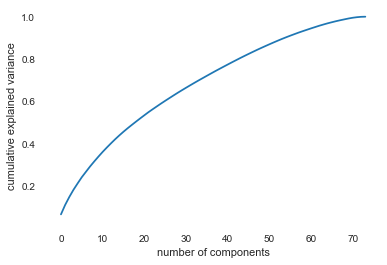

In [277]:
pca = PCA(n_components='mle', svd_solver='full')
pca.fit_transform(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [292]:
pca = PCA(n_components=65).fit(X_train_scaled)
pca.fit(X_test_scaled)

PCA(n_components=65)

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=7)

In [302]:
rfc = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1)

In [303]:
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)

In [304]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      4522
           1       0.48      0.37      0.42       847
           2       0.81      0.85      0.83      6511

    accuracy                           0.79     11880
   macro avg       0.70      0.67      0.68     11880
weighted avg       0.78      0.79      0.79     11880



In [323]:
xgb_model = XGBClassifier(objective='multi:softprob')

xgb_model.fit(X_train, y_train)
preds2 = xgb_model.predict(X_test)

In [326]:
xgbc = XGBClassifier(learning_rate=0.5,
                    n_estimators=150,
                    max_depth=6,
                    min_child_weight=0,
                    gamma=0,
                    reg_lambda=1,
                    subsample=1,
                    colsample_bytree=0.75,
                    scale_pos_weight=1,
                    objective='multi:softprob',
                    num_class=3,
                    random_state=42)

mcl = xgbc.fit(X_train, y_train, eval_metric='mlogloss')
preds2 = mcl.predict(X_test)

[20:59:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [327]:
print(classification_report(y_test,preds2))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78      4522
           1       0.55      0.32      0.41       847
           2       0.78      0.89      0.83      6511

    accuracy                           0.79     11880
   macro avg       0.72      0.65      0.67     11880
weighted avg       0.78      0.79      0.78     11880



In [283]:
result = pd.DataFrame(rfc.predict(X_test_scaled), columns=['status_group'])
result

,status_group
0,2
1,2
2,2
3,0
4,2
...,...
14845,0
14846,2
14847,2
14848,2


In [284]:
result_df = result_df.join(result)

In [285]:
result_df = result_df[['id','status_group']]
result_df = result_df.set_index('id')

In [286]:
val_status_group={2:'functional', 1:'functional needs repair',
                   0:'non functional'}
result_df['status_group']=result_df.status_group.replace(val_status_group)
result_df

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
...,...
39307,non functional
18990,functional
28749,functional


In [287]:
submission = result_df.to_csv('submission.csv')